# **SONG LYRICS ANALYSIS OVER LAST DECADE**
In this project i have anlysed song lyrics from 2010 to 2019.I wanted to know how the lyrics varied over time I have analysize 

1.   Average number of words in songs per year. 
2.   Vocabulary Efficiency i.e the avg number of unique words in songs.
3.   Top words used in songs per year.
4.   Topic Modeling to depict more meaning from the lyrics and plot it's varitation over time.



## 1)Data Collection:
I used the top 10 songs from year 2010 to 2019.
The lyrics were scrapped from genius.com using their API.

In [ ]:
#Define function to scrape lyrics from Genius.com


import requests
from bs4 import BeautifulSoup
import os
import re

GENIUS_API_TOKEN=##YOUR KEY GOES HERE



def get_song_url(title,artist):
  base_url = 'https://api.genius.com'
  headers = {'Authorization': 'Bearer ' + GENIUS_API_TOKEN}  
  search_url = base_url + "/search"
  song_title=title
  artist_name = artist
  data = {'q': artist_name + song_title}
  response = requests.get(search_url, data=data, headers=headers)
  json = response.json()
 
  songs=[]
  song_info =[]

  for hit in json["response"]["hits"]:
      song_info.append(hit)

  for song in song_info:
    url= song["result"]["url"]
    songs.append(url)
  return songs
    
 
def scrape_song_lyrics(url):
    page = requests.get(url)
    html = BeautifulSoup(page.text, 'html.parser')
    if html.find('div', class_='lyrics')==None:
      return None
    lyrics = html.find('div', class_='lyrics').get_text()
    lyrics = re.sub(r'[\(\[].*?[\)\]]', '', lyrics)
    lyrics = os.linesep.join([s for s in lyrics.splitlines() if s])         
    return lyrics



In [ ]:
#imported a list of top songs and creating a dataframe to store all results 
import pandas as pd
music_data=pd.read_csv('/content/drive/My Drive/Colab Notebooks/Book1.csv')

s_urls=[]
s_lyrics=[]
for i,x in music_data.iterrows():
  title=x['SONG_NAME'].lower()
  artist=x['ARTIST_NAME'].lower()
  x=get_song_url(title,artist)
  s_urls.append(x[0])
for url in s_urls:
  lyrics=scrape_song_lyrics(url)
  s_lyrics.append(lyrics)


  


In [ ]:
#Saving the data
music_data['lyrics']=s_lyrics
music_data.info()
music_data.head()
music_data.to_csv('/content/drive/My Drive/Colab Notebooks/Book2.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   YEAR            100 non-null    int64 
 1   RANK            100 non-null    int64 
 2   SONG_NAME       100 non-null    object
 3   ARTIST_NAME     100 non-null    object
 4   TOTAL_AUDIENCE  30 non-null     object
 5   SINGER_GENDER   100 non-null    object
 6   lyrics          100 non-null    object
dtypes: int64(2), object(5)
memory usage: 5.6+ KB


## 2)Data Cleaning
Perform cleaning operations on the lyrics removed all the redundant words.

In [3]:
#Importing the saved csv file 
import pandas as pd
music_data=pd.read_csv('/content/drive/My Drive/Colab Notebooks/Book2.csv')
pd.options.display.max_colwidth=100
music_data.head(5)

,Unnamed: 0,YEAR,RANK,SONG_NAME,ARTIST_NAME,TOTAL_AUDIENCE,SINGER_GENDER,lyrics
0,0,2010,1,Need You Know,Lady A,"6,00,000",F,"""Hey, sorry I missed your call, just leave a message after the beep""\n""Hey, yeah, it's me, just ..."
1,1,2010,2,"Hey, Soul Sister",Train,"5,40,000",M,Heyy\nHe-e-e-e-ey\nHe-e-e-e-ey\nYour lipstick stains\nOn the front lobe of my left-side brains\n...
2,2,2010,3,California Gurls,Katy Perry,"5,03,000",F,"Greetings, loved ones\nLet's take a journey\nI know a place where the grass is really greener\nW..."
3,3,2010,4,Nothin' On You,B.o.B.,"4,85,000",M,Beautiful girls\nAll over the world\nI could be chasin'\nBut my time would be wasted\nThey got n...
4,4,2010,5,OMG,Usher,"4,70,000",M,"Oh my gosh\nBaby let me\nI did it again, so I'm gon' let the beat rock\nOh my\nBaby, let me love..."


In [4]:
#Creating a Clean Lyrics function to clean the lyrics remove all the meaningless data
import os 
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from string import punctuation

STOPWORDS = set(stopwords.words('english'))
punctuation = list(punctuation)
STOPWORDS.update(punctuation)


def clean_lyric(text):
  text = text.lower()
  text = re.sub('\[.*?\'-]', ' ', text)
  text = re.sub('https?://\S+|www\.\S+', ' ', text)
  text = re.sub('<.*?>+', ' ', text)
  text = re.sub('\n', ' ', text)
  text = re.sub('\w*\d\w*', ' ', text)
  text = re.sub(r'[\(\[].*?[\)\]]','',text)
 
  
  clean_text = []
  for w in word_tokenize(text):
    if w.lower() not in STOPWORDS and w.isalpha()==True and len(w)>2:
      clean_text.append(w)
  text = " ".join(clean_text)
    
  return text





[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [5]:
music_data['cleaned_lyrics']=music_data['lyrics'].apply(clean_lyric)
music_data.head()

,Unnamed: 0,YEAR,RANK,SONG_NAME,ARTIST_NAME,TOTAL_AUDIENCE,SINGER_GENDER,lyrics,cleaned_lyrics
0,0,2010,1,Need You Know,Lady A,"6,00,000",F,"""Hey, sorry I missed your call, just leave a message after the beep""\n""Hey, yeah, it's me, just ...",hey sorry missed call leave message beep hey yeah thinking everything night know miss much call ...
1,1,2010,2,"Hey, Soul Sister",Train,"5,40,000",M,Heyy\nHe-e-e-e-ey\nHe-e-e-e-ey\nYour lipstick stains\nOn the front lobe of my left-side brains\n...,heyy lipstick stains front lobe brains knew would forget went let blow mind sweet moonbeam smell...
2,2,2010,3,California Gurls,Katy Perry,"5,03,000",F,"Greetings, loved ones\nLet's take a journey\nI know a place where the grass is really greener\nW...",greetings loved ones let take journey know place grass really greener warm wet wild must somethi...
3,3,2010,4,Nothin' On You,B.o.B.,"4,85,000",M,Beautiful girls\nAll over the world\nI could be chasin'\nBut my time would be wasted\nThey got n...,beautiful girls world could chasin time would wasted got nothin baby nothin baby might say might...
4,4,2010,5,OMG,Usher,"4,70,000",M,"Oh my gosh\nBaby let me\nI did it again, so I'm gon' let the beat rock\nOh my\nBaby, let me love...",gosh baby let gon let beat rock baby let love many ways love baby break many ways love got like ...


## 3)Data Analysis and Visualization

1.   Bar plot of average number of words and unique words over the past 10 years.
2.   Worldcloud of year 2014,2017 viz.highest and lowest lyrics complexcity.



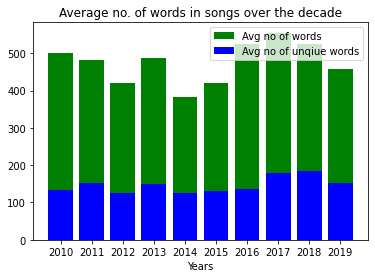

In [6]:
#plotting word count and unique words avg per year
import matplotlib.pyplot as plt
fig,ax=plt.subplots()

years=music_data['YEAR'].unique()
word_counts=[]
unique_words=[]
def word_count(text):
  token=word_tokenize(text)
  x=len(token)
  tset=set(token)
  y=len(tset)
  return x , y

music_data['word_counts']=music_data['lyrics'].apply(word_count)

for year in years:
  sum=0
  usum=0
  x=music_data[music_data['YEAR']==year].reset_index()
  for ind in x.index:
    sum=x['word_counts'][ind][0]+sum
    usum=x['word_counts'][ind][1]+usum
  word_counts.append(int(sum/len(x)))
  unique_words.append(int(usum/len(x)))

ax.bar(years,word_counts,color='g')
ax.bar(years,unique_words,color='b')
ax.set_xlabel("Years")
plt.xticks(years,years)
ax.set_title("Average no. of words in songs over the decade")
ax.legend(labels=['Avg no of words','Avg no of unqiue words'])
plt.show()



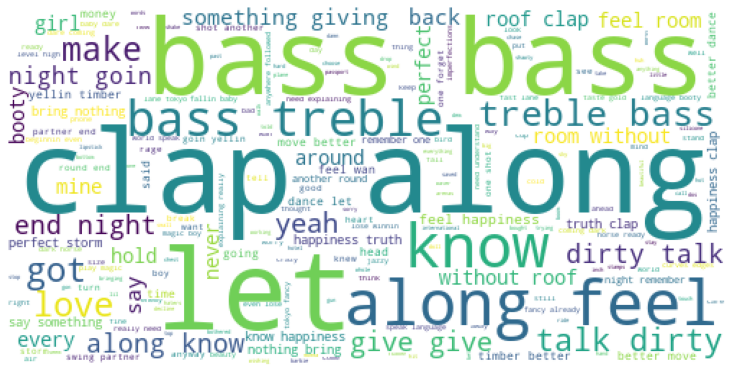

In [7]:
#Creating a wordcloud for year 2014 lowest complexity of songs as the average no of words is lowest

from wordcloud import WordCloud 
import matplotlib.pyplot as plt 

lowest_words=music_data[music_data['YEAR']==2014].reset_index()
text1=''
for ind in lowest_words.index:
  text1=text1+lowest_words['cleaned_lyrics'][ind]




def wordcloud(text):  
    wordcloud = WordCloud(width =500,
                          height =250,
                          background_color="white",
                          max_words=250                         
                         ).generate(text)
    plt.figure(figsize=(10,15))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()
    return;

wordcloud1 = wordcloud(text1)


 


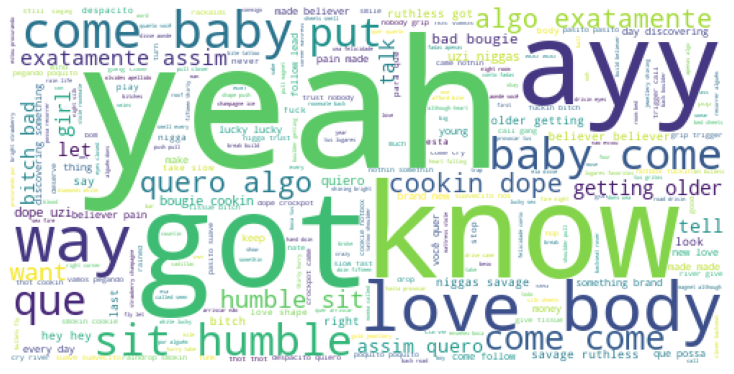

In [8]:
#Creating wordcloud for year 2017 highest complextiy of lyrics as no of words is highest
highest_words=music_data[music_data['YEAR']==2017].reset_index()
text2=''

for ind in highest_words.index:
  text2=text2+highest_words['cleaned_lyrics'][ind]

wordcloud2 = wordcloud(text2)

## 3)TOPIC MODELING NLTK USING LDA
In this we have used LDA technique of NLTK to perfom topic modeling on the lyrics and we derive 5 main topics and plot their variation overtime.



In [30]:
#For topic modelling selecting only the verb noun and adjectives from the lyrics as they are proven to be most usefull for analysis than others.
mdata_copy=music_data.copy()
mdata_copy=mdata_copy.drop(['RANK','ARTIST_NAME','SINGER_GENDER','TOTAL_AUDIENCE','lyrics','word_counts'],axis=1)

from nltk import word_tokenize, pos_tag
nltk.download('averaged_perceptron_tagger')


def nouns_adj(text):
    is_noun_adj = lambda pos: pos[:2] == 'NN' or pos[:2] == 'JJ' or pos[:2]== 'VB'
    tokenized = word_tokenize(text)
    nouns_adj = [word for (word, pos) in pos_tag(tokenized) if is_noun_adj(pos)] 
    return ' '.join(nouns_adj)
mdata_copy=mdata_copy['cleaned_lyrics'].apply(nouns_adj)
mdata_copy.head()


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


0    hey sorry missed call leave message beep hey yeah thinking everything night know much call pictu...
1    heyy lipstick stains front lobe brains knew forget went let blow mind sweet moonbeam smell singl...
2    greetings loved ones let take journey know place grass greener warm wet wild something water sip...
3    beautiful girls world chasin time wasted got nothin baby nothin baby say say hey worry say got n...
4    gosh baby let gon let beat rock baby let love many ways love baby break many ways love got gosh ...
Name: cleaned_lyrics, dtype: object

In [31]:
#Topic Modeling 
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words=stopwords.words('english')
stop_words.extend(['back','got','ooh','gon','said','come','one','yeah','place','would','like','know','stay','go','let','cause','see','side','call','done','mama','put','get','hey','wan','tell','say','talk','man'])
vectorizer=TfidfVectorizer(stop_words=stop_words,min_df=0.1)
tfid=vectorizer.fit_transform(mdata_copy)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [32]:
from sklearn.decomposition import NMF
nmf=NMF(n_components=5)
topic_values=nmf.fit_transform(tfid)
for topic_num,topic in enumerate(nmf.components_):
  message="Topic #{}:".format(topic_num+1)
  message+=" ".join([vectorizer.get_feature_names()[i] for i in topic.argsort()[:-11 :-1]])
  print(message)

Topic #1:bad feel take baby show make shit look made give
Topic #2:want girl good mind way stop tonight leave getting something
Topic #3:need think girl right time hold used night hope hand
Topic #4:love baby heart think give touch life hand something mean
Topic #5:sorry home tonight everything times heart time hope world something


In [34]:
topic_labels=['Breakup/Sad','Fun/Party','Relationship','Love/Life','World hope']
df_topics=pd.DataFrame(topic_values,columns=topic_labels)
df_topics.head()

,Breakup/Sad,Fun/Party,Relationship,Love/Life,World hope
0,0.000000,0.000000,0.609853,0.000000,0.075236
1,0.007760,0.354737,0.040870,0.043041,0.150905
2,0.042054,0.052353,0.015306,0.323229,0.044666
3,0.146957,0.005082,0.000000,0.196424,0.003403
4,0.000000,0.297157,0.000000,0.486936,0.000000


In [40]:
#Adjusting the values in the data frame to zero and one respectively based on a threshold value
song_topic=music_data.join(df_topics)
song_topic.loc[song_topic['Breakup/Sad']>=0.1,'Breakup/Sad']=1
song_topic.loc[song_topic['Fun/Party']>=0.1,'Fun/Party']=1
song_topic.loc[song_topic['Relationship']>=0.1,'Relationship']=1
song_topic.loc[song_topic['Love/Life']>=0.1,'Love/Life']=1
song_topic.loc[song_topic['World hope']>=0.1,'World hope']=1



song_topic.loc[song_topic['Breakup/Sad']<0.1,'Breakup/Sad']=0
song_topic.loc[song_topic['Fun/Party']<0.1,'Fun/Party']=0
song_topic.loc[song_topic['Relationship']<0.1,'Relationship']=0
song_topic.loc[song_topic['Love/Life']<0.1,'Love/Life']=0
song_topic.loc[song_topic['World hope']<0.1,'World hope']=0

In [44]:
year_topics=song_topic.groupby('YEAR').sum().reset_index()
year_topics.head(10)

,YEAR,Unnamed: 0,RANK,Breakup/Sad,Fun/Party,Relationship,Love/Life,World hope
0,2010,45,55,2.0,4.0,2.0,4.0,2.0
1,2011,145,55,5.0,4.0,2.0,3.0,2.0
2,2012,245,55,3.0,1.0,2.0,3.0,3.0
3,2013,345,55,5.0,2.0,3.0,4.0,0.0
4,2014,445,55,6.0,2.0,4.0,2.0,2.0
5,2015,545,55,3.0,1.0,2.0,2.0,2.0
6,2016,645,55,2.0,1.0,5.0,1.0,3.0
7,2017,745,55,6.0,1.0,1.0,2.0,0.0
8,2018,845,54,6.0,2.0,1.0,2.0,2.0
9,2019,945,55,7.0,3.0,2.0,2.0,0.0


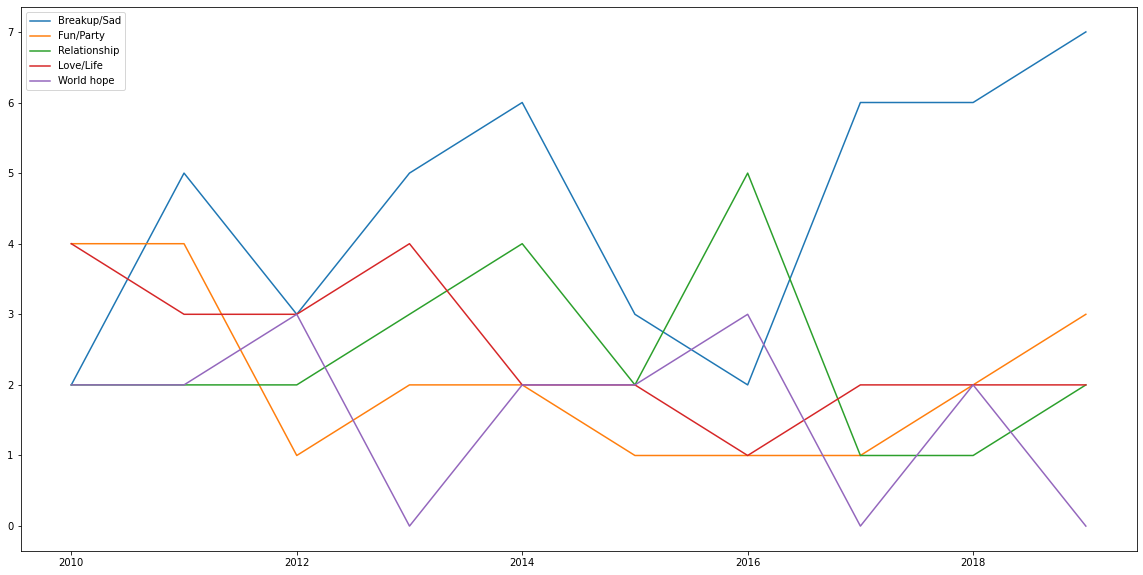

In [45]:
#Time visiualization of the topics.
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(year_topics['YEAR'],year_topics['Breakup/Sad'],label='Breakup/Sad')
plt.plot(year_topics['YEAR'],year_topics['Fun/Party'],label='Fun/Party')
plt.plot(year_topics['YEAR'],year_topics['Relationship'],label='Relationship')
plt.plot(year_topics['YEAR'],year_topics['Love/Life'],label='Love/Life')
plt.plot(year_topics['YEAR'],year_topics['World hope'],label='World hope')
plt.legend()
